# HW2A: Alignment with IBM Model 1


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import math
import matplotlib.pyplot as plt # graphs and figures
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import string
from collections import Counter
from itertools import product
import tqdm.notebook
import pickle

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Data

We'll start out by using a toy dataset. Please see [these slides](https://cal-cs288.github.io/sp20/slides/cs288_sp20_05_statistical_translation_4up.pdf) for a more complete coverage of IBM Model 1, and feel free to check out Philipp Koehn's book _Statistical Machine Translation_. 

In [2]:
aligned_data = [
    (["das", "haus"], ["the", "house"]),
    (["das", "buch"], ["the", "book"]),
    (["ein", "buch"], ["a", "book"]),
]

## Alignment Model

Fill in the code for IBM Model 1 below. A correct implementation should achieve perplexity 4096 on the first iteration and perplexity around 70 by the tenth iteration, for the toy dataset above. Note that we'll be grading you only on the generated `self.translation_probabilities`, so the probability and perplexity functions only exist for you to check the correctness of your own implementation. You may wish to comment them out during implementation and check that `self.translation_probabilities` looks reasonable instead.

In [3]:
class IBMModel1:
    def __init__(self, data, num_iterations=10, epsilon=1.0, compute_perplexity=True):
        self.data = data # aligned corpus as shown above
        self.num_iterations = num_iterations # iterations of expectation-maximization
        self.epsilon = epsilon
        self.compute_perplexity = compute_perplexity

        # Preprocess bitext data:
        self.source_words, self.target_words = set(), set()
        for (source,target) in self.data:
            self.source_words.update(source)
            self.target_words.update(target)

        # Initialize uniform probabilities:
        self.translation_probs = {(s,t): 1.0/len(self.target_words)
                                  for s,t in product(self.source_words, self.target_words)}

    def e_step(self):
        # YOUR SOLUTION HERE
        # - Iterate over paired sentences in the data and compute:
        # - (1) counts, the number of times a source word is translated into a target word,
        #       weighted by alignment probabilities
        # - (2) total, the sum of counts for all possible target words
        # See slide 32 for more information: https://cal-cs288.github.io/sp20/slides/cs288_sp20_05_statistical_translation_4up.pdf
        # BEGIN SOLUTION

        counts = {(s,t): 0 for s,t in product(self.source_words, self.target_words)}
        total = {t: 0 for t in self.target_words}
        for source, target in self.data:
            for s, t in zip(source, target):
                counts[(s,t)] += self.translation_probs[(s,t)]
                total[t] += self.translation_probs[(s,t)]

        return counts, total

        # END SOLUTION

    def m_step(self, counts, total):
        # YOUR SOLUTION HERE
        # - Update self.translation_probs using counts and total
        # BEGIN SOLUTION

        for s, t in self.translation_probs:
            if total[t] == 0:
                self.translation_probs[(s,t)] = 0
            else:
                self.translation_probs[(s,t)] = counts[(s,t)] / total[t]

        return self.translation_probs

        # END SOLUTION

    def train(self):
        # Run EM for self.num_iterations:
        for idx in tqdm.tqdm(range(self.num_iterations)):
            if self.compute_perplexity: 
                print("Iteration: {} | Perplexity: {}".format(idx, self.perplexity()))
            counts, total = self.e_step()
            self.m_step(counts, total)
        if self.compute_perplexity:
            print("Iteration: {} | Perplexity: {}".format(self.num_iterations, self.perplexity()))

    def probability(self, source, target):
        # YOUR SOLUTION HERE
        # - Use the normalization trick from lecture to efficiently compute probabilities
        # - We'll use self.epsilon here, which is defined in the initialization
        # BEGIN SOLUTION

        counts = 1
        for s, t in zip(source, target):
            counts *= self.translation_probs[(s,t)]

        total = 1
        for t in target:
            tot = 0
            for s in source:
                tot += self.translation_probs[(s,t)]
            total *= tot

        return counts/total

        # END SOLUTION

    def perplexity(self):
        # YOUR SOLUTION HERE
        # - Iterate over each pair of sentences in the dataset
        # - Call self.probability and compute a sum in log space
        # - Feel free to comment this out while testing your initial model
        # BEGIN SOLUTION

        log_probabilities = []
        for source, target in self.data:
            log_probabilities.append(math.log(self.probability(source, target), 2))

        return 2 ** -np.mean(log_probabilities)

        # END SOLUTION

    def get_alignment(self, source, target):
        # YOUR SOLUTION HERE
        # - Find the best word alignment for a source, target pair
        # - Output a list of [(source_idx, target_idx)]
        #   For example: (["ein", "buch"], ["a", "book"])
        #   should have an alignment [(0,0), (1,1)]
        # BEGIN SOLUTION

        alignment = []
        for i, s in enumerate(source):
            align = ()
            max_prob = -1
            for j, t in enumerate(target):
                prob = self.translation_probs[(s,t)]
                if prob > max_prob:
                    align = (i, j)
                    max_prob = prob
            alignment.append(align)

        return alignment

        # END SOLUTION

ibm = IBMModel1(aligned_data)
ibm.train()
assert(ibm.get_alignment(["ein", "buch"], ["a", "book"]) == [(0, 0), (1, 1)])
with open("./saves/example_alignments.pkl", "wb") as outfile:
    pickle.dump(ibm.translation_probs, outfile, protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████| 10/10 [00:00<00:00, 18682.87it/s]

Iteration: 0 | Perplexity: 4.0
Iteration: 1 | Perplexity: 1.0
Iteration: 2 | Perplexity: 1.0
Iteration: 3 | Perplexity: 1.0
Iteration: 4 | Perplexity: 1.0
Iteration: 5 | Perplexity: 1.0
Iteration: 6 | Perplexity: 1.0
Iteration: 7 | Perplexity: 1.0
Iteration: 8 | Perplexity: 1.0
Iteration: 9 | Perplexity: 1.0
Iteration: 10 | Perplexity: 1.0


## Visualization and Analysis

Write code to visualize alignments and rerun the IBM model on a (very slightly larger) toy dataset:

100%|██████████| 1/1 [00:00<00:00, 4660.34it/s]


Iteration: 0 | Perplexity: 43.08869380063765
Iteration: 1 | Perplexity: 2.3973570328492273


<Figure size 640x480 with 0 Axes>

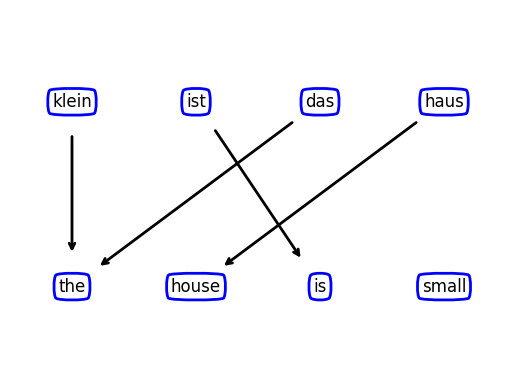

In [4]:
def visualize_alignment(source, target, alignment):
    # YOUR SOLUTION HERE
    # BEGIN ALIGNMENT

    plt.clf()
    fig, ax = plt.subplots()
    ax.set_xlim(-0.5, len(alignment)-0.5)
    ax.set_ylim(-0.5, 1.5)

    bbox_props = dict(boxstyle="round4,pad=0.3", fc="none", ec="b", lw=2)
    for i, (s, t) in enumerate(zip(source, target)):
        ax.text(i, 1, s, ha="center", va="center",
                size=12, bbox=bbox_props)
        ax.text(i, 0, t, ha="center", va="center",
                size=12, bbox=bbox_props)

    for s, t in alignment:
        ax.annotate("", xy=(t, 0), xycoords='data',
                    xytext=(s, 1), textcoords='data',
                    arrowprops=dict(
                        arrowstyle="->", color="k", lw=2,
                        shrinkA=25, shrinkB=25, patchA=None, patchB=None,
                        connectionstyle="arc3,rad=0",))

    plt.axis('off')
    plt.show()

    # END ALIGNMENT

aligned_data = [
    (['klein', 'ist', 'das', 'haus'], ['the', 'house', 'is', 'small']),
    (['das', 'haus', 'ist', 'ja', 'groß'], ['the', 'house', 'is', 'big']),
    (['das', 'buch', 'ist', 'ja', 'klein'], ['the', 'book', 'is', 'small']),
    (['das', 'haus'], ['the', 'house']),
    (['das', 'buch'], ['the', 'book']),
    (['ein', 'buch'], ['a', 'book'])
]
ibm = IBMModel1(aligned_data, num_iterations=1)
ibm.train()

source, target = aligned_data[0]
alignment = ibm.get_alignment(source, target)
visualize_alignment(source, target, alignment)

We'll now run the IBM model on a significantly larger dataset to showcase its failure modes:

In [5]:
import sentencepiece

from torchtext.legacy import data
from torchtext.legacy import datasets

In [6]:
# Load the Multi30K translation dataset:
extensions = [".de", ".en"]
source_field = data.Field(tokenize=lambda x: x)
target_field = data.Field(tokenize=lambda x: x)
training_data, validation_data, test_data = datasets.Multi30k.splits(
    extensions, [source_field, target_field], root=".")

In [7]:
def preprocess(sentence):
    sentence = sentence.translate(str.maketrans('', '', string.punctuation)) # strip punctuation
    return sentence.strip().lower().split()

aligned_data = []
for example in training_data[:1000]:
    source = preprocess(example.src)
    target = preprocess(example.trg)
    aligned_data.append((source, target))

ibm = IBMModel1(aligned_data, compute_perplexity=False)
ibm.train()
with open("./saves/multi30k_alignments.pkl", "wb") as outfile:
    pickle.dump(ibm.translation_probs, outfile, protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████| 10/10 [00:47<00:00,  4.72s/it]


In [8]:
# Making sure the model learned something:
examples = [
    ("hund", "dog"),
    ("hund", "cat"),
    ("ein", "a"),
    ("ein", "the"),
    ("frau", "woman"),
    ("frau", "man"),
]


for example in examples:
    print(str(example) + ": " + str(ibm.translation_probs[example]))

('hund', 'dog'): 0.9999999999998458
('hund', 'cat'): 0.0
('ein', 'a'): 0.9998776447342016
('ein', 'the'): 5.461614381029826e-16
('frau', 'woman'): 0.9999999999778143
('frau', 'man'): 0.0


From this larger dataset: find at least one sentence where the IBM alignment model performs reasonably well, and find another one where it fails catastrophically, and include alignment visualizations for both examples in your report. You may want to consult a [German-English dictionary](https://www.collinsdictionary.com/us/dictionary/english-german) for this part of the problem. Provide a brief explanation for why the alignment model did poorly on the failure case.